In [1]:
from openqaoa import QAOA, create_device
import networkx as nx
import matplotlib.pyplot as plt
from openqaoa.problems import MinimumVertexCover, MaximumCut
from openqaoa.utilities import plot_graph
from qiskit import IBMQ
import numpy as np
from pprint import pprint

IBMQ.save_account(
    "1b0ab941b010112fea6054ef44befc6d05ea3eca559a8b7b9dcaf68adcac0a64b6f24eafce9f69b96e6bf67eb223e27c7085ab8da9e12a0ba54f10c48616effa"
)

/var/folders/ph/hp043kk921q2v4grp3l2v6nw0000gq/T/ipykernel_77180/2664292147.py:10: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.save_account(
/var/folders/ph/hp043kk921q2v4grp3l2v6nw0000gq/T/ipykernel_77180/2664292147.py:10: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  IBMQ.save_account(


In [2]:
g = nx.generators.fast_gnp_random_graph(n=6, p=0.6, seed=42)

#graphProblem = MinimumVertexCover(g, field=1.0, penalty=30)
graphProblem = MaximumCut(g)
qubo_problem = graphProblem.qubo

Ground State energy: -6.0, Solution: ['001110', '110001']


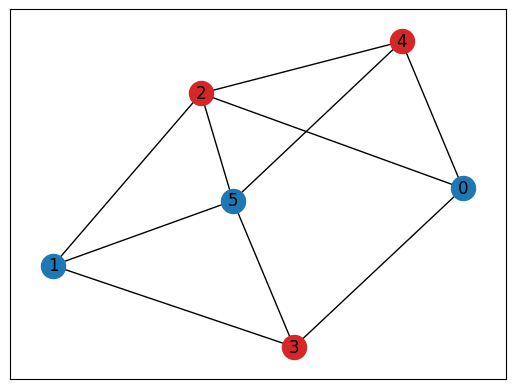

In [3]:
#Optional block, this is finding the exact solutions to the problem, useful for checking if the QAOA is configured well
hamiltonian = qubo_problem.hamiltonian
# import the brute-force solver to obtain exact solution
from openqaoa.utilities import ground_state_hamiltonian
energy, configuration = ground_state_hamiltonian(hamiltonian)
print(f"Ground State energy: {energy}, Solution: {configuration}")
#plot the solution on graph
pos =  nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '1'], node_color="tab:red")
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '0'], node_color="tab:blue")
nx.draw_networkx_edges(g, pos)
nx.draw_networkx_labels(g, pos, labels={node: node for node in g.nodes()});

In [4]:
#Local simulation block
# Create the QAOA
q = QAOA()

# Load account from disk
IBMQ.load_account()
# Create a device
local_CPU = create_device(location="local", name="qiskit.qasm_simulator")
q.set_device(local_CPU)


# circuit properties. This method allows to shape the properties of the ansats circuit.
# It is the place where you can select the number of layers p, the type desired parametrization (and its initialization),
# and the type of mixer that you want to use.
q.set_circuit_properties(
    p=3, param_type="standard", init_type="ramp", mixer_hamiltonian="xy"
)

# backend properties. here we are fixing: - The number of shots: this is a fundamental value when running computations on a QPU or on a shot-based simulator -
# The initial round of Hamiltonians is set to True -
# Setting the value for the Conditional Value-at-Risk, a trick employed during the calculation of the expectation value
q.set_backend_properties(init_hadamard=True, n_shots=8000, cvar_alpha=0.85)

# classical optimizer properties. Note that since we are running the computation over the cloud we set maxiter=200 (that is, we cap the number of circuit evaluations to 200)
# and set a tolerance tol=0.05, roughly meaning that we will stop the optimization loop as soon as gains between consecutive cost values are smaller than the tolerance.
# Currently OpenQAOA allows both for gradient based and gradient free optimization methods, together with a wide selections of optimizers inherited both by SciPy and PennyLane.
q.set_classical_optimizer(method="cobyla", maxiter=200, tol=0.01)

In [5]:
q.compile(qubo_problem)

In [6]:
q.optimize()

(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'Cost history'}, xlabel='Number of function evaluations', ylabel='Cost'>)

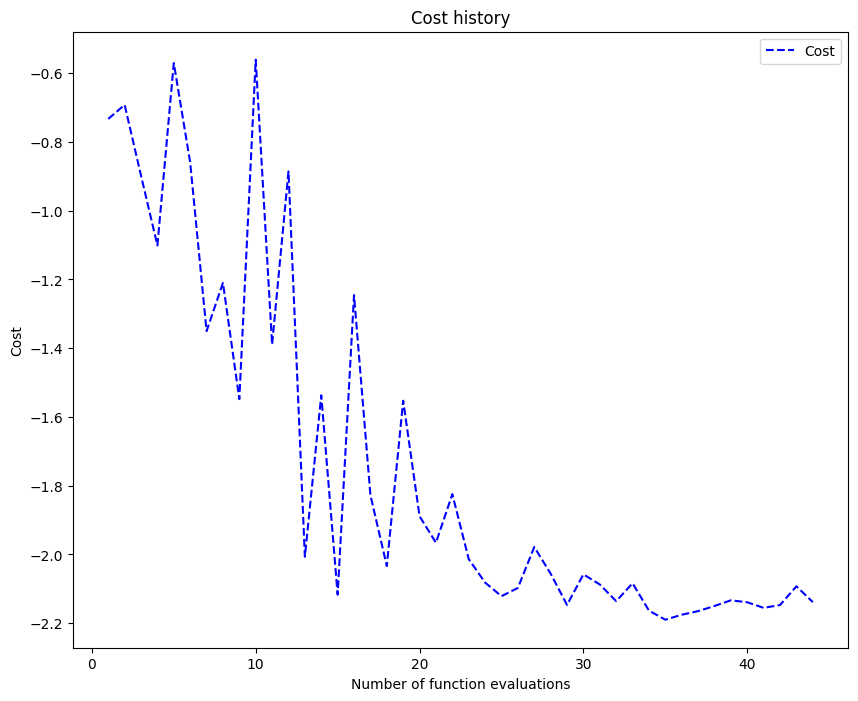

In [7]:
q.result.plot_cost()

In [8]:
results = q.result.optimized
binaryStrings = results['measurement_outcomes']
sortedBS = sorted(binaryStrings.items(), key=lambda item: item[1], reverse=True)
print(sortedBS[:8])
#pprint(results) #uncomment for all results

[('100000', 462), ('001100', 459), ('110011', 453), ('110000', 452), ('001111', 436), ('011111', 419), ('110001', 358), ('001110', 343)]


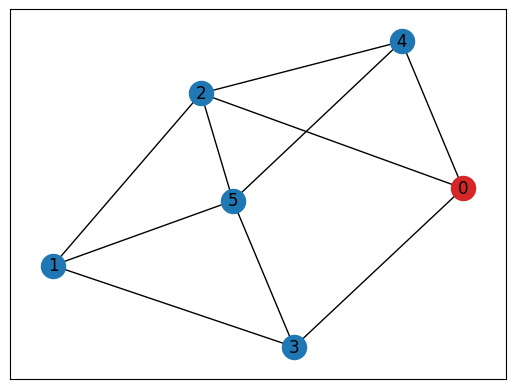

In [9]:
bestSolution = sortedBS[:1][0][0]
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(bestSolution) if bit == '1'], node_color="tab:red")
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(bestSolution) if bit == '0'], node_color="tab:blue")
nx.draw_networkx_edges(g, pos)
nx.draw_networkx_labels(g, pos, labels={node: node for node in g.nodes()});

In [10]:
variational_params = q.optimizer.variational_params
#create the optimized QAOA circuit for qiskit backend
optimized_angles = results['angles']
variational_params.update_from_raw(optimized_angles)
optimized_circuit = q.backend.qaoa_circuit(variational_params)

#print the optimized QAOA circuit for qiskit backend
optimized_circuit.draw()

┌───┐                                                                 »
  q1_0: ┤ H ├─■────────────■─────────────────────────■────────────────────────»
        ├───┤ │            │                         │                        »
  q1_1: ┤ H ├─┼────────────┼────────────■────────────┼────────────■───────────»
        ├───┤ │ZZ(1.0058)  │            │ZZ(1.0058)  │            │           »
  q1_2: ┤ H ├─■────────────┼────────────■────────────┼────────────┼───────────»
        ├───┤              │ZZ(1.0058)               │            │ZZ(1.0058) »
  q1_3: ┤ H ├──────────────■─────────────────────────┼────────────■───────────»
        ├───┤                                        │ZZ(1.0058)              »
  q1_4: ┤ H ├────────────────────────────────────────■────────────────────────»
        ├───┤                                                                 »
  q1_5: ┤ H ├─────────────────────────────────────────────────────────────────»
        └───┘                                                                 »
meas: 6/══════════════════════════════════════════════════════════════════════»
                                                                              »
«                     ┌───────────────┐┌───────────────┐┌───────────────┐»
«  q1_0: ─────────────┤0              ├┤0              ├┤0              ├»
«                     │  Rxx(0.48948) ││  Ryy(0.48948) ││               │»
«  q1_1: ─■───────────┤1              ├┤1              ├┤  Rxx(0.48948) ├»
«         │           └───────────────┘└───────────────┘│               │»
«  q1_2: ─┼──────────────■────────────────■─────────────┤1              ├»
«         │              │                │             └───────────────┘»
«  q1_3: ─┼──────────────┼────────────────┼────────────────■─────────────»
«         │              │ZZ(1.0058)      │                │             »
«  q1_4: ─┼──────────────■────────────────┼────────────────┼─────────────»
«         │ZZ(1.0058)                     │ZZ(1.0058)      │ZZ(1.0058)   »
«  q1_5: ─■───────────────────────────────■────────────────■─────────────»
«                                                                        »
«meas: 6/════════════════════════════════════════════════════════════════»
«                                                                        »
«        ┌───────────────┐┌───────────────┐                 ┌───────────────┐»
«  q1_0: ┤0              ├┤0              ├─────────────────┤0              ├»
«        │               ││               │┌───────────────┐│               │»
«  q1_1: ┤  Ryy(0.48948) ├┤               ├┤0              ├┤               ├»
«        │               ││  Rxx(0.48948) ││  Rxx(0.48948) ││  Ryy(0.48948) │»
«  q1_2: ┤1              ├┤               ├┤1              ├┤               ├»
«        └───────────────┘│               │└───────────────┘│               │»
«  q1_3: ─────────────────┤1              ├─────────────────┤1              ├»
«                         └───────────────┘                 └───────────────┘»
«  q1_4: ───■────────────────────────────────────────────────────────────────»
«           │ZZ(1.0058)                                                      »
«  q1_5: ───■────────────────────────────────────────────────────────────────»
«                                                                            »
«meas: 6/════════════════════════════════════════════════════════════════════»
«                                                                            »
«                         ┌───────────────┐                 ┌───────────────┐»
«  q1_0: ─────────────────┤0              ├─────────────────┤0              ├»
«        ┌───────────────┐│               │┌───────────────┐│               │»
«  q1_1: ┤0              ├┤               ├┤0              ├┤               ├»
«        │  Ryy(0.48948) ││               ││               ││               │»
«  q1_2: ┤1              ├┤  Rxx(0.48948) ├┤  Rxx(0.48948) ├┤  Ryy(0.48948) ├»
«        └──────────────